In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np
import io

import matplotlib.pyplot as plt
from utils import setup_seed
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss
from tensorboardX import SummaryWriter
import cv2
import io


import argparse
import os
import torch
from tqdm import tqdm
import pdb
import numpy as np

import matplotlib.pyplot as plt
from utils import setup_seed, keep_bbox_from_image_range, \
    keep_bbox_from_lidar_range, write_pickle, write_label, \
    iou2d, iou3d_camera, iou_bev
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Function to plot the scalars and convert the plot to a tensor image
def plot_scalars(scalars, step):
    fig, ax = plt.subplots()
    ax.plot(scalars)
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Scalar Index')
    ax.set_ylabel('Value')
    plt.grid(True)

    # Convert the plot to a PNG image
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)

    # Convert PNG buffer to a tensor image
    image = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)  # Decode the image
    image = torch.from_numpy(image).permute(2, 0, 1)#.unsqueeze(0)  # Convert to PyTorch tensor and add batch dimension
    return image

def save_summary(writer, loss_dict, global_step, tag, gating_prob, lr=None, momentum=None, model=None, data=None, flag=False):
    for k, v in loss_dict.items():
        writer.add_scalar(f'{tag}/{k}', v, global_step)
    if lr is not None:
        writer.add_scalar('lr', lr, global_step)
    if momentum is not None:
        writer.add_scalar('momentum', momentum, global_step)
    if model is not None and global_step % 1000 == 0:
        for tag, value in model.named_parameters():
            # import pdb
            # pdb.set_trace()
            if value.grad is not None:
                writer.add_histogram(tag + "/grad", value.grad.cpu(), global_step)
    
    if global_step % 100 == 0:
        image = plot_scalars(gating_prob.detach().cpu().numpy(), global_step)
        writer.add_image("Scalars Plot", image, global_step=global_step)
    # for i in data:
    #     del i['gt_names']
    #     del i['image_info']
    #     del i['calib_info']
    #     del i['difficulty']

    # writer.add_graph(model, data)



### Training Arguments

In [3]:
class Args:
    def __init__(self):
        self.data_root = "dataset/KITTI"
        self.saved_path = "logs/pillar_sequence_mem_lin_gat_9_param_share_test"
        self.saved_path_exact = self.saved_path + "/results_exact"
        self.saved_path_estimate = self.saved_path + "/results_estimate"
        self.batch_size = 1
        self.num_workers = 4
        self.window_length = 1
        self.nclasses = 3
        self.init_lr = 0.00025
        self.max_epoch = 200
        self.log_freq = 1        
        self.ckpt_freq_epoch = 2
        self.val_freq_epoch = 2
        self.no_cuda = not torch.cuda.is_available()
 
args = Args()

### Dataloader

In [4]:
train_dataset = Kitti(data_root=args.data_root,
                        split='train')
val_dataset = Kitti(data_root=args.data_root,
                    split='val')
train_dataloader = get_dataloader(dataset=train_dataset, 
                                    batch_size=args.batch_size, 
                                    num_workers=args.num_workers,
                                    shuffle=True)
val_dataloader = get_dataloader(dataset=val_dataset, 
                                batch_size=args.batch_size, 
                                num_workers=args.num_workers,
                                shuffle=False)

# data = train_dataset.__getitem__(9)

train_dataset_length = len(train_dataset.sorted_ids)
train_dataset_batch_count =  train_dataset_length 
val_dataset_length = len(val_dataset.sorted_ids)

def get_sequence_from_velodyne_path(file_path):
    parts = file_path.split('/')
    file_name = parts[-1]
    extracted_part = file_name.split('_')[0]
    return extracted_part

# Print the extracted part

CLASSES = Kitti.CLASSES
LABEL2CLASSES = {v:k for k, v in CLASSES.items()}


pcd_limit_range = np.array([0, -40, -3, 70.4, 40, 0.0], dtype=np.float32)


### Model, Loss, Optimizer, Scheduler, Log

In [5]:
if not args.no_cuda:
    pointpillars = PointPillars(nclasses=args.nclasses).cuda()
else:
    pointpillars = PointPillars(nclasses=args.nclasses)

model_flag = False

loss_func = Loss()

max_iters = 2* train_dataset_batch_count * args.max_epoch
init_lr = args.init_lr
optimizer = torch.optim.AdamW(params=pointpillars.parameters(), 
                                lr=init_lr, 
                                betas=(0.95, 0.99),
                                weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,  
                                                max_lr=init_lr*10, 
                                                total_steps=max_iters, 
                                                pct_start=0.4, 
                                                anneal_strategy='cos',
                                                cycle_momentum=True, 
                                                base_momentum=0.95*0.895, 
                                                max_momentum=0.95,
                                                div_factor=10)


saved_logs_path = os.path.join(args.saved_path, 'summary')
import shutil
if os.path.exists(saved_logs_path):
    shutil.rmtree(saved_logs_path)
os.makedirs(saved_logs_path, exist_ok=True)
writer = SummaryWriter(saved_logs_path)
saved_ckpt_path = os.path.join(args.saved_path, 'checkpoints')
os.makedirs(saved_ckpt_path, exist_ok=True)

# Directory for exact results
saved_path_exact = args.saved_path_exact
os.makedirs(saved_path_exact, exist_ok=True)
saved_submit_path_exact = os.path.join(saved_path_exact, 'submit')
os.makedirs(saved_submit_path_exact, exist_ok=True)

# Directory for estimate results
saved_path_estimate = args.saved_path_estimate
os.makedirs(saved_path_estimate, exist_ok=True)
saved_submit_path_estimate = os.path.join(saved_path_estimate, 'submit')
os.makedirs(saved_submit_path_estimate, exist_ok=True)


### Validation Stuff

In [6]:
def get_score_thresholds(tp_scores, total_num_valid_gt, num_sample_pts=41):
    score_thresholds = []
    tp_scores = sorted(tp_scores)[::-1]
    cur_recall, pts_ind = 0, 0
    for i, score in enumerate(tp_scores):
        lrecall = (i + 1) / total_num_valid_gt
        rrecall = (i + 2) / total_num_valid_gt

        if i == len(tp_scores) - 1:
            score_thresholds.append(score)
            break

        if (lrecall + rrecall) / 2 < cur_recall:
            continue

        score_thresholds.append(score)
        pts_ind += 1
        cur_recall = pts_ind / (num_sample_pts - 1)
    return score_thresholds

In [7]:
def do_eval(det_results, gt_results, CLASSES, saved_path):
    '''
    det_results: list,
    gt_results: dict(id -> det_results)
    CLASSES: dict
    '''
    assert len(det_results) == len(gt_results)
    f = open(os.path.join(saved_path, 'eval_results.txt'), 'w')

    # 1. calculate iou
    ious = {
        'bbox_2d': [],
        'bbox_bev': [],
        'bbox_3d': []
    }
    ids = list(sorted(gt_results.keys()))
    for id in ids:
        gt_result = gt_results[id]['annos']
        det_result = det_results[id]

        # 1.1, 2d bboxes iou
        gt_bboxes2d = gt_result['bbox'].astype(np.float32)
        det_bboxes2d = det_result['bbox'].astype(np.float32)
        iou2d_v = iou2d(torch.from_numpy(gt_bboxes2d).cuda(), torch.from_numpy(det_bboxes2d).cuda())
        ious['bbox_2d'].append(iou2d_v.cpu().numpy())

        # 1.2, bev iou
        gt_location = gt_result['location'].astype(np.float32)
        gt_dimensions = gt_result['dimensions'].astype(np.float32)
        gt_rotation_y = gt_result['rotation_y'].astype(np.float32)
        det_location = det_result['location'].astype(np.float32)
        det_dimensions = det_result['dimensions'].astype(np.float32)
        det_rotation_y = det_result['rotation_y'].astype(np.float32)

        gt_bev = np.concatenate([gt_location[:, [0, 2]], gt_dimensions[:, [0, 2]], gt_rotation_y[:, None]], axis=-1)
        det_bev = np.concatenate([det_location[:, [0, 2]], det_dimensions[:, [0, 2]], det_rotation_y[:, None]], axis=-1)
        iou_bev_v = iou_bev(torch.from_numpy(gt_bev).cuda(), torch.from_numpy(det_bev).cuda())
        ious['bbox_bev'].append(iou_bev_v.cpu().numpy())

        # 1.3, 3dbboxes iou
        gt_bboxes3d = np.concatenate([gt_location, gt_dimensions, gt_rotation_y[:, None]], axis=-1)
        det_bboxes3d = np.concatenate([det_location, det_dimensions, det_rotation_y[:, None]], axis=-1)
        iou3d_v = iou3d_camera(torch.from_numpy(gt_bboxes3d).cuda(), torch.from_numpy(det_bboxes3d).cuda())
        ious['bbox_3d'].append(iou3d_v.cpu().numpy())

    MIN_IOUS = {
        'Pedestrian': [0.5, 0.5, 0.5],
        'Cyclist': [0.5, 0.5, 0.5],
        'Car': [0.7, 0.7, 0.7]
    }
    MIN_HEIGHT = [40, 25, 25]

    overall_results = {}
    for e_ind, eval_type in enumerate(['bbox_2d', 'bbox_bev', 'bbox_3d']):
        eval_ious = ious[eval_type]
        eval_ap_results, eval_aos_results = {}, {}
        for cls in CLASSES:
            eval_ap_results[cls] = []
            eval_aos_results[cls] = []
            CLS_MIN_IOU = MIN_IOUS[cls][e_ind]
            for difficulty in [0, 1, 2]:
                # 1. bbox property
                total_gt_ignores, total_det_ignores, total_dc_bboxes, total_scores = [], [], [], []
                total_gt_alpha, total_det_alpha = [], []
                for id in ids:
                    gt_result = gt_results[id]['annos']
                    det_result = det_results[id]

                    # 1.1 gt bbox property
                    cur_gt_names = gt_result['name']
                    cur_difficulty = gt_result['difficulty']
                    gt_ignores, dc_bboxes = [], []
                    for j, cur_gt_name in enumerate(cur_gt_names):
                        ignore = cur_difficulty[j] < 0 or cur_difficulty[j] > difficulty
                        if cur_gt_name == cls:
                            valid_class = 1
                        elif cls == 'Pedestrian' and cur_gt_name == 'Person_sitting':
                            valid_class = 0
                        elif cls == 'Car' and cur_gt_name == 'Van':
                            valid_class = 0
                        else:
                            valid_class = -1
                        
                        if valid_class == 1 and not ignore:
                            gt_ignores.append(0)
                        elif valid_class == 0 or (valid_class == 1 and ignore):
                            gt_ignores.append(1)
                        else:
                            gt_ignores.append(-1)
                        
                        if cur_gt_name == 'DontCare':
                            dc_bboxes.append(gt_result['bbox'][j])
                    total_gt_ignores.append(gt_ignores)
                    total_dc_bboxes.append(np.array(dc_bboxes))
                    total_gt_alpha.append(gt_result['alpha'])

                    # 1.2 det bbox property
                    cur_det_names = det_result['name']
                    cur_det_heights = det_result['bbox'][:, 3] - det_result['bbox'][:, 1]
                    det_ignores = []
                    for j, cur_det_name in enumerate(cur_det_names):
                        if cur_det_heights[j] < MIN_HEIGHT[difficulty]:
                            det_ignores.append(1)
                        elif cur_det_name == cls:
                            det_ignores.append(0)
                        else:
                            det_ignores.append(-1)
                    total_det_ignores.append(det_ignores)
                    total_scores.append(det_result['score'])
                    total_det_alpha.append(det_result['alpha'])

                # 2. calculate scores thresholds for PR curve
                tp_scores = []
                for i, id in enumerate(ids):
                    cur_eval_ious = eval_ious[i]
                    gt_ignores, det_ignores = total_gt_ignores[i], total_det_ignores[i]
                    scores = total_scores[i]

                    nn, mm = cur_eval_ious.shape
                    assigned = np.zeros((mm, ), dtype=np.bool_)
                    for j in range(nn):
                        if gt_ignores[j] == -1:
                            continue
                        match_id, match_score = -1, -1
                        for k in range(mm):
                            if not assigned[k] and det_ignores[k] >= 0 and cur_eval_ious[j, k] > CLS_MIN_IOU and scores[k] > match_score:
                                match_id = k
                                match_score = scores[k]
                        if match_id != -1:
                            assigned[match_id] = True
                            if det_ignores[match_id] == 0 and gt_ignores[j] == 0:
                                tp_scores.append(match_score)
                total_num_valid_gt = np.sum([np.sum(np.array(gt_ignores) == 0) for gt_ignores in total_gt_ignores])
                score_thresholds = get_score_thresholds(tp_scores, total_num_valid_gt)    
            
                # 3. draw PR curve and calculate mAP
                tps, fns, fps, total_aos = [], [], [], []

                for score_threshold in score_thresholds:
                    tp, fn, fp = 0, 0, 0
                    aos = 0
                    for i, id in enumerate(ids):
                        cur_eval_ious = eval_ious[i]
                        gt_ignores, det_ignores = total_gt_ignores[i], total_det_ignores[i]
                        gt_alpha, det_alpha = total_gt_alpha[i], total_det_alpha[i]
                        scores = total_scores[i]

                        nn, mm = cur_eval_ious.shape
                        assigned = np.zeros((mm, ), dtype=np.bool_)
                        for j in range(nn):
                            if gt_ignores[j] == -1:
                                continue
                            match_id, match_iou = -1, -1
                            for k in range(mm):
                                if not assigned[k] and det_ignores[k] >= 0 and scores[k] >= score_threshold and cur_eval_ious[j, k] > CLS_MIN_IOU:
    
                                    if det_ignores[k] == 0 and cur_eval_ious[j, k] > match_iou:
                                        match_iou = cur_eval_ious[j, k]
                                        match_id = k
                                    elif det_ignores[k] == 1 and match_iou == -1:
                                        match_id = k

                            if match_id != -1:
                                assigned[match_id] = True
                                if det_ignores[match_id] == 0 and gt_ignores[j] == 0:
                                    tp += 1
                                    if eval_type == 'bbox_2d':
                                        aos += (1 + np.cos(gt_alpha[j] - det_alpha[match_id])) / 2
                            else:
                                if gt_ignores[j] == 0:
                                    fn += 1
                            
                        for k in range(mm):
                            if det_ignores[k] == 0 and scores[k] >= score_threshold and not assigned[k]:
                                fp += 1
                        
                        # In case 2d bbox evaluation, we should consider dontcare bboxes
                        if eval_type == 'bbox_2d':
                            dc_bboxes = total_dc_bboxes[i]
                            det_bboxes = det_results[id]['bbox']
                            if len(dc_bboxes) > 0:
                                ious_dc_det = iou2d(torch.from_numpy(det_bboxes), torch.from_numpy(dc_bboxes), metric=1).numpy().T
                                for j in range(len(dc_bboxes)):
                                    for k in range(len(det_bboxes)):
                                        if det_ignores[k] == 0 and scores[k] >= score_threshold and not assigned[k]:
                                            if ious_dc_det[j, k] > CLS_MIN_IOU:
                                                fp -= 1
                                                assigned[k] = True
                            
                    tps.append(tp)
                    fns.append(fn)
                    fps.append(fp)
                    if eval_type == 'bbox_2d':
                        total_aos.append(aos)

                tps, fns, fps = np.array(tps), np.array(fns), np.array(fps)

                precisions = tps / (tps + fns) # actually this is recalls
                # precisions = tps / (tps + fps)
                for i in range(len(score_thresholds)):
                    precisions[i] = np.max(precisions[i:])
                
                sums_AP = 0
                for i in range(0, len(score_thresholds), 4):
                    sums_AP += precisions[i]
                mAP = sums_AP / 11 * 100
                eval_ap_results[cls].append(mAP)

                if eval_type == 'bbox_2d':
                    total_aos = np.array(total_aos)
                    similarity = total_aos / (tps + fps)
                    for i in range(len(score_thresholds)):
                        similarity[i] = np.max(similarity[i:])
                    sums_similarity = 0
                    for i in range(0, len(score_thresholds), 4):
                        sums_similarity += similarity[i]
                    mSimilarity = sums_similarity / 11 * 100
                    eval_aos_results[cls].append(mSimilarity)

        print(f'=========={eval_type.upper()}==========')
        print(f'=========={eval_type.upper()}==========', file=f)
        for k, v in eval_ap_results.items():
            print(f'{k} AP@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
            print(f'{k} AP@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
        if eval_type == 'bbox_2d':
            print(f'==========AOS==========')
            print(f'==========AOS==========', file=f)
            for k, v in eval_aos_results.items():
                print(f'{k} AOS@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
                print(f'{k} AOS@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
        
        overall_results[eval_type] = np.mean(list(eval_ap_results.values()), 0)
        if eval_type == 'bbox_2d':
            overall_results['AOS'] = np.mean(list(eval_aos_results.values()), 0)
    
    print(f'\n==========Overall==========')
    print(f'\n==========Overall==========', file=f)
    for k, v in overall_results.items():
        print(f'{k} AP: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
        print(f'{k} AP: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
    f.close()

### Training

In [8]:
def measure_losses(bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict):
    
    ################# Full features #################
    bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
    bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
    bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)

    batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
    batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
    batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
    batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)

    pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

    bbox_pred0 = bbox_pred0[pos_idx]
    batched_bbox_reg = batched_bbox_reg[pos_idx]
    batched_bbox_reg0 = batched_bbox_reg.clone()

    # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
    bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
    batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
    bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
    batched_dir_labels = batched_dir_labels[pos_idx]
    num_cls_pos = (batched_bbox_labels < args.nclasses).sum()
    bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


    batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
    batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

    loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                            bbox_pred=bbox_pred0,
                            bbox_dir_cls_pred=bbox_dir_cls_pred0,
                            batched_labels=batched_bbox_labels, 
                            num_cls_pos=num_cls_pos, 
                            batched_bbox_reg=batched_bbox_reg0, 
                            batched_dir_labels=batched_dir_labels)

    # gLoss = torch.sum(p*torch.norm(y-ye, dim=(1,2,3)))
    # l2 norm
    # gLoss = (((1-g)*(y-ye)).pow(2).sum(dim=(1,2,3)).pow(0.5)).sum()

    return loss_dict0

In [9]:
def regularize(model, lambd = 1.01):

    A = model.pillar_encoder.global_masks[0]
    # B = torch.tensor([lambd ** i for i in range(len(A))], dtype=torch.float32).unsqueeze(0).to(A.device)
    _, indices = torch.sort(A, dim=1, descending=True)
    B = torch.pow(lambd, indices)
    regularized_loss = torch.sum(A * B)


    A = model.neck.global_masks[0]
    _, indices = torch.sort(A, dim=1, descending=True)
    B = torch.pow(lambd, indices)
    regularized_loss += torch.sum(A * B)


    for A in model.backbone.global_masks:
        _, indices = torch.sort(A, dim=1, descending=True)
        B = torch.pow(lambd, indices)
        regularized_loss += torch.sum(A * B)


    return regularized_loss

# def regularize2(model, lambd = 1.1):

#     A = model.pillar_encoder.global_masks[0]
#     B = torch.tensor([lambd ** i for i in range(A.shape[1])], dtype=torch.float32).unsqueeze(0).to(A.device)
#     A_sorted, indices = torch.sort(A, descending=True)
#     regularized_loss = torch.sum(A_sorted * B)

#     A = model.neck.global_masks[0]
#     B = torch.tensor([lambd ** i for i in range(A.shape[1])], dtype=torch.float32).unsqueeze(0).to(A.device)
#     A_sorted, indices = torch.sort(A, descending=True)
#     regularized_loss += torch.sum(A_sorted * B)


#     for A in model.backbone.global_masks:
#         B = torch.tensor([lambd ** i for i in range(A.shape[1])], dtype=torch.float32).unsqueeze(0).to(A.device)
#         A_sorted, indices = torch.sort(A, descending=True)
#         regularized_loss += torch.sum(A_sorted * B)


#     return regularized_loss



In [10]:
def bugicugi(bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict):
    bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
    bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
    bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)

    batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
    batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
    batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
    batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)

    pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

    bbox_pred0 = bbox_pred0[pos_idx]

    batched_bbox_reg = batched_bbox_reg[pos_idx]
    batched_bbox_reg0 = batched_bbox_reg.clone()

    # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
    bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
    batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
    bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]


    batched_dir_labels = batched_dir_labels[pos_idx]

    num_cls_pos = (batched_bbox_labels < args.nclasses).sum()

    bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


    batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
    batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

    loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                            bbox_pred=bbox_pred0,
                            bbox_dir_cls_pred=bbox_dir_cls_pred0,
                            batched_labels=batched_bbox_labels, 
                            num_cls_pos=num_cls_pos, 
                            batched_bbox_reg=batched_bbox_reg0, 
                            batched_dir_labels=batched_dir_labels)
    return loss_dict0

In [11]:
# # pointpillars.load_state_dict(torch.load("logs/pillar_sequence_memory_gating_binary/checkpoints/epoch_60.pth"))
checkpoint = torch.load("logs/pillar_sequence_mem_lin_gat_8_masking_pruning/checkpoints/epoch_3.pth.tar")
pointpillars.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch0 = checkpoint['epoch']
# loss = checkpoint['loss']

# training_loss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/train_loss.npy").tolist()
# training_gLoss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/train_gloss.npy").tolist()
# val_loss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/val_loss.npy").tolist()
# val_gLoss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/val_gloss.npy").tolist()

training_loss0 = []
training_gLoss0 = []

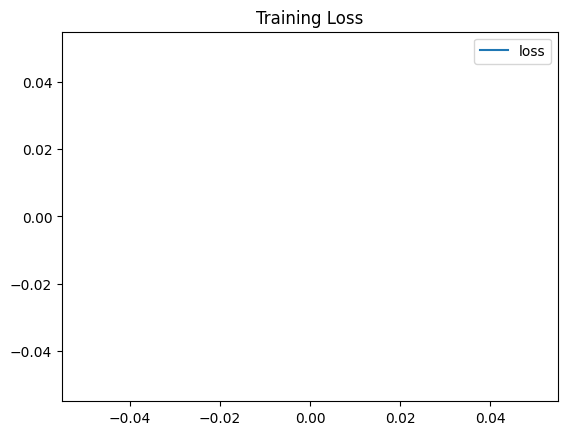

Predicting and Formatting the results.


 12%|█▏        | 101/866 [00:08<01:03, 12.11it/s]


Evaluating.. Please wait several seconds.
> /home/sayeed/uncertainty_estimation/point_cloud/PointPillars/utils/process.py(440)iou2d()
    438         import pdb; pdb.set_trace()
    439 
--> 440     bboxes_w = torch.clamp(bboxes_x2 - bboxes_x1, min=0)
    441     bboxes_h = torch.clamp(bboxes_y2 - bboxes_y1, min=0)
    442 

torch.Size([5, 4])
torch.Size([0])
torch.Size([0])
*** NameError: name 'format_results' is not defined
*** NameError: name 'format_results' is not defined


In [15]:
from itertools import islice

epoch0 = 2
global_step=0

for epoch in range(epoch0, args.max_epoch):
# for epoch in range(1):
    # epoch_loss0 = 0
    # epoch_gLoss0 = 0

    # train_indices = np.random.randint(train_dataset_length, size=train_dataset_batch_count)

    # print('=' * 20, epoch, '=' * 20)

    # train_step, val_step = 0, 0

    # pointpillars.train()

    # for i, data_dict in enumerate(tqdm(train_dataloader)):
    #     if not args.no_cuda:
    #         # move the tensors to the cuda
    #         for key in data_dict:
    #             for j, item in enumerate(data_dict[key]):
    #                 if torch.is_tensor(item):
    #                     data_dict[key][j] = data_dict[key][j].cuda()
        
    #     optimizer.zero_grad()

    #     batched_pts = data_dict['batched_pts']
    #     batched_gt_bboxes = data_dict['batched_gt_bboxes']
    #     batched_labels = data_dict['batched_labels']
    #     batched_difficulty = data_dict['batched_difficulty']

    #     ################# Full features #################

    #     bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict0, \
    #             bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, anchor_target_dict1, \
    #                 bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2, anchor_target_dict2 = pointpillars(batched_pts=batched_pts, 
    #                                 mode='train',
    #                                 batched_gt_bboxes=batched_gt_bboxes, 
    #                                 batched_gt_labels=batched_labels)

    #     loss_dict0 = bugicugi(bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict0)
    #     loss_dict1 = bugicugi(bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, anchor_target_dict1)
    #     loss_dict2 = bugicugi(bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2, anchor_target_dict2)

    #     loss = loss_dict0['total_loss'] + loss_dict1['total_loss'] + loss_dict2['total_loss'] 
    #     loss.backward()

    #     epoch_loss0 += epoch_loss0 + loss.item()

    #     # ################# Half features #################

    #     # bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict = pointpillars(batched_pts=batched_pts, 
    #     #                             mode='train',
    #     #                             batched_gt_bboxes=batched_gt_bboxes, 
    #     #                             batched_gt_labels=batched_labels, level=1)

    #     # loss_dict0 = bugicugi(bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict)
    #     # loss = loss_dict0['total_loss'] 
    #     # loss.backward()
        
    #     # epoch_loss0 += epoch_loss0 + loss.item()

    #     # ################# Quart features #################

    #     # bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict = pointpillars(batched_pts=batched_pts, 
    #     #                             mode='train',
    #     #                             batched_gt_bboxes=batched_gt_bboxes, 
    #     #                             batched_gt_labels=batched_labels, level=2)

    #     # loss_dict0 = bugicugi(bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict)
    #     # loss = loss_dict0['total_loss'] 
    #     # loss.backward()
        
    #     # epoch_loss0 += epoch_loss0 + loss.item()



    #     # torch.nn.utils.clip_grad_norm_(pointpillars.parameters(), max_norm=35)
    #     optimizer.step()
    #     scheduler.step()

    
    #     train_step += 1

    #     global_step = 2*train_dataset_batch_count*epoch + train_step

    #     # if global_step % args.log_freq == 0:
    #     #     save_summary(writer, loss_dict, global_step, 'train', p,
    #     #                     lr=optimizer.param_groups[0]['lr'], 
    #     #                     momentum=optimizer.param_groups[0]['betas'][0],
    #     #                     model=pointpillars, data=data_cuda, flag=model_flag)

    # training_loss.append(loss.item())

    if epoch % args.ckpt_freq_epoch == 0:

        checkpoint = {
        'epoch': epoch,
        'model_state_dict': pointpillars.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }   
        torch.save(checkpoint, os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth.tar'))
    ###################################### Validation ######################################

    if (epoch % args.val_freq_epoch) == 0 and epoch >0:
    # if (epoch % args.val_freq_epoch) == 0:

        plt.figure()
        plt.plot(np.array(training_loss0))
        plt.title("Training Loss")
        plt.legend(["loss", "g_loss"])
        plt.show()

        ################################### Validation ###################################
        pointpillars.eval()

        with torch.no_grad():
            format_results = {}
            print('Predicting and Formatting the results.')
            for i, data_dict in enumerate(tqdm(val_dataloader)):
                if i > 100:
                    break
                if not args.no_cuda:
                    # move the tensors to the cuda
                    for key in data_dict:
                        for j, item in enumerate(data_dict[key]):
                            if torch.is_tensor(item):
                                data_dict[key][j] = data_dict[key][j].cuda()
                
                batched_pts = data_dict['batched_pts']
                batched_gt_bboxes = data_dict['batched_gt_bboxes']
                batched_labels = data_dict['batched_labels']
                batched_difficulty = data_dict['batched_difficulty']
                batch_results0  = pointpillars(batched_pts=batched_pts,
                                        mode='val0',
                                        batched_gt_bboxes=batched_gt_bboxes, 
                                        batched_gt_labels=batched_labels)

                for j, result in enumerate(batch_results0):
                    format_result = {
                        'name': [],
                        'truncated': [],
                        'occluded': [],
                        'alpha': [],
                        'bbox': [],
                        'dimensions': [],
                        'location': [],
                        'rotation_y': [],
                        'score': []
                    }
                    
                    calib_info = data_dict['batched_calib_info'][j]
                    tr_velo_to_cam = calib_info['Tr_velo_to_cam'].astype(np.float32)
                    r0_rect = calib_info['R0_rect'].astype(np.float32)
                    P2 = calib_info['P2'].astype(np.float32)
                    image_shape = data_dict['batched_img_info'][j]['image_shape']
                    idx = data_dict['batched_img_info'][j]['image_idx']
                    result_filter = keep_bbox_from_image_range(result, tr_velo_to_cam, r0_rect, P2, image_shape)
                    result_filter = keep_bbox_from_lidar_range(result_filter, pcd_limit_range)

                    lidar_bboxes = result_filter['lidar_bboxes']
                    labels, scores = result_filter['labels'], result_filter['scores']
                    bboxes2d, camera_bboxes = result_filter['bboxes2d'], result_filter['camera_bboxes']
                    
                    for lidar_bbox, label, score, bbox2d, camera_bbox in \
                        zip(lidar_bboxes, labels, scores, bboxes2d, camera_bboxes):
                        format_result['name'].append(LABEL2CLASSES[label])
                        format_result['truncated'].append(0.0)
                        format_result['occluded'].append(0)
                        alpha = camera_bbox[6] - np.arctan2(camera_bbox[0], camera_bbox[2])
                        format_result['alpha'].append(alpha)
                        format_result['bbox'].append(bbox2d)
                        format_result['dimensions'].append(camera_bbox[3:6])
                        format_result['location'].append(camera_bbox[:3])
                        format_result['rotation_y'].append(camera_bbox[6])
                        format_result['score'].append(score)
                    
                    write_label(format_result, os.path.join(args.saved_path_exact, f'{idx:06d}.txt'))

                    format_results[idx] = {k:np.array(v) for k, v in format_result.items()}
            
            write_pickle(format_results, os.path.join(args.saved_path, 'results.pkl'))

        print('Evaluating.. Please wait several seconds.')
        # do_eval(format_results, val_dataset.data_infos, CLASSES, args.saved_path)
        do_eval(format_results, dict(islice(val_dataset.data_infos.items(), i)), CLASSES, args.saved_path)
        
  

In [25]:
list(sorted(val_dataset.data_infos.keys()))

[2000000,
 2000001,
 2000002,
 2000003,
 2000004,
 2000005,
 2000006,
 2000007,
 2000008,
 2000009,
 2000010,
 2000011,
 2000012,
 2000013,
 2000014,
 2000015,
 2000016,
 2000017,
 2000018,
 2000019,
 2000020,
 2000021,
 2000022,
 2000023,
 2000024,
 2000025,
 2000026,
 2000027,
 2000028,
 2000029,
 2000030,
 2000031,
 2000032,
 2000033,
 2000034,
 2000035,
 2000036,
 2000037,
 2000038,
 2000039,
 2000040,
 2000041,
 2000042,
 2000043,
 2000044,
 2000045,
 2000046,
 2000047,
 2000048,
 2000049,
 2000050,
 2000051,
 2000052,
 2000053,
 2000054,
 2000055,
 2000056,
 2000057,
 2000058,
 2000059,
 2000060,
 2000061,
 2000062,
 2000063,
 2000064,
 2000065,
 2000066,
 2000067,
 2000068,
 2000069,
 2000070,
 2000071,
 2000072,
 2000073,
 2000074,
 2000075,
 2000076,
 2000077,
 2000078,
 2000079,
 2000080,
 2000081,
 2000082,
 2000083,
 2000084,
 2000085,
 2000086,
 2000087,
 2000088,
 2000089,
 2000090,
 2000091,
 2000092,
 2000093,
 2000094,
 2000095,
 2000096,
 2000097,
 2000098,
 2000099,


In [35]:
format_results[2000009]

{'name': array([], dtype=float64),
 'truncated': array([], dtype=float64),
 'occluded': array([], dtype=float64),
 'alpha': array([], dtype=float64),
 'bbox': array([], dtype=float64),
 'dimensions': array([], dtype=float64),
 'location': array([], dtype=float64),
 'rotation_y': array([], dtype=float64),
 'score': array([], dtype=float64)}

In [ ]:

'''
==========BBOX_2D==========
Pedestrian AP@0.5: 12.5541 12.0594 12.0594
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 90.3473 85.0690 82.6321
==========AOS==========
Pedestrian AOS@0.5: 2.2431 1.8547 1.8547
Cyclist AOS@0.5: 0.0884 9.7744 9.7744
Car AOS@0.7: 90.1198 88.3073 86.8500
==========BBOX_BEV==========
Pedestrian AP@0.5: 17.3160 12.9870 12.9870
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 86.9970 81.8544 71.0886
==========BBOX_3D==========
Pedestrian AP@0.5: 11.4719 10.9462 10.9462
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 71.3308 56.4050 53.9020

==========Overall==========
bbox_2d AP: 40.3611 54.9838 54.1715
AOS AP: 30.8171 33.3121 32.8263
bbox_bev AP: 40.8316 49.4766 45.8880
bbox_3d AP: 33.6615 32.0198 31.1854


==========BBOX_2D==========
Pedestrian AP@0.5: 12.3377 11.1317 11.1317
Cyclist AP@0.5: 3.4091 39.3541 39.3541
Car AP@0.7: 71.9899 55.0626 53.1738
==========AOS==========
Pedestrian AOS@0.5: 2.9628 2.4612 2.4612
Cyclist AOS@0.5: 0.0064 2.0339 2.0339
Car AOS@0.7: 74.2191 63.3802 62.0901
==========BBOX_BEV==========
Pedestrian AP@0.5: 10.1732 6.8182 6.8182
Cyclist AP@0.5: 3.4091 11.9617 11.9617
Car AP@0.7: 57.2220 39.6281 37.3518
==========BBOX_3D==========
Pedestrian AP@0.5: 5.1948 3.1540 3.1540
Cyclist AP@0.5: 3.4091 5.7416 5.7416
Car AP@0.7: 39.7968 26.3120 20.4752

==========Overall==========
bbox_2d AP: 29.2456 35.1828 34.5532
AOS AP: 25.7295 22.6251 22.1951
bbox_bev AP: 23.6014 19.4693 18.7106
bbox_3d AP: 16.1336 11.7359 9.7903
'''

'\n==========BBOX_2D==========\nPedestrian AP@0.5: 12.5541 12.0594 12.0594\nCyclist AP@0.5: 18.1818 67.8230 67.8230\nCar AP@0.7: 90.3473 85.0690 82.6321\n==========AOS==========\nPedestrian AOS@0.5: 2.2431 1.8547 1.8547\nCyclist AOS@0.5: 0.0884 9.7744 9.7744\nCar AOS@0.7: 90.1198 88.3073 86.8500\n==========BBOX_BEV==========\nPedestrian AP@0.5: 17.3160 12.9870 12.9870\nCyclist AP@0.5: 18.1818 53.5885 53.5885\nCar AP@0.7: 86.9970 81.8544 71.0886\n==========BBOX_3D==========\nPedestrian AP@0.5: 11.4719 10.9462 10.9462\nCyclist AP@0.5: 18.1818 28.7081 28.7081\nCar AP@0.7: 71.3308 56.4050 53.9020\n\n==========Overall==========\nbbox_2d AP: 40.3611 54.9838 54.1715\nAOS AP: 30.8171 33.3121 32.8263\nbbox_bev AP: 40.8316 49.4766 45.8880\nbbox_3d AP: 33.6615 32.0198 31.1854\n'

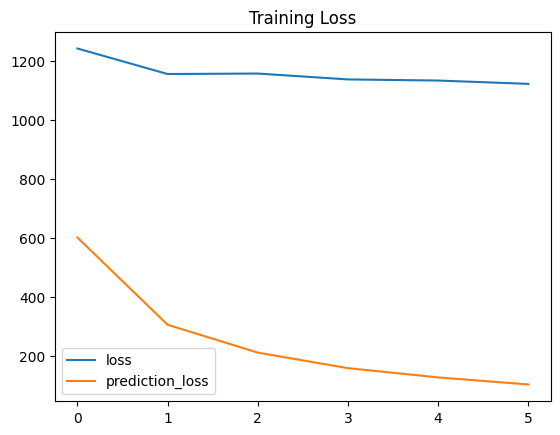

In [ ]:

    #     global_step = epoch * len(train_dataloader) + train_step + 1

    #     if global_step % args.log_freq == 0:
    #         save_summary(writer, loss_dict0, global_step, 'train',
    #                         lr=optimizer.param_groups[0]['lr'], 
    #                         momentum=optimizer.param_groups[0]['betas'][0])
    #     train_step += 1

    # training_loss0.append(epoch_loss0)
    # training_gLoss0.append(epoch_gLoss0.detach().cpu())

    # if epoch % 2 == 0:
    #     continue

    # pointpillars.eval()
    # with torch.no_grad():
    #     for i, data_dict in enumerate(tqdm(val_dataloader)):
    #         try:
    #             if not args.no_cuda:
    #                 # move the tensors to the cuda
    #                 for key in data_dict:
    #                     for j, item in enumerate(data_dict[key]):
    #                         if torch.is_tensor(item):
    #                             data_dict[key][j] = data_dict[key][j].cuda()
                
    #             batched_pts = data_dict['batched_pts']
    #             batched_gt_bboxes = data_dict['batched_gt_bboxes']
    #             batched_labels = data_dict['batched_labels']
    #             batched_difficulty = data_dict['batched_difficulty']

    #             bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict, x, xe = pointpillars(batched_pts=batched_pts, 
    #                                         batched_pts0=batched_pts0, 
    #                                         mode='train',
    #                                         batched_gt_bboxes=batched_gt_bboxes, 
    #                                         batched_gt_labels=batched_labels)\
    #                 # bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, \
    #                 #     bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2,  = \

                
    #             ################# Full features #################
    #             bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
    #             bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
    #             bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)



    #             batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
    #             batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
    #             batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
    #             batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


                
    #             pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

    #             bbox_pred0 = bbox_pred0[pos_idx]


    #             batched_bbox_reg = batched_bbox_reg[pos_idx]
    #             batched_bbox_reg0 = batched_bbox_reg.clone()

    #             # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
    #             bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
    #             batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
    #             bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
    #             batched_dir_labels = batched_dir_labels[pos_idx]
    #             num_cls_pos = (batched_bbox_labels < args.nclasses).sum()
    #             bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


    #             batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
    #             batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

    #             loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
    #                                     bbox_pred=bbox_pred0,
    #                                     bbox_dir_cls_pred=bbox_dir_cls_pred0,
    #                                     batched_labels=batched_bbox_labels, 
    #                                     num_cls_pos=num_cls_pos, 
    #                                     batched_bbox_reg=batched_bbox_reg0, 
    #                                     batched_dir_labels=batched_dir_labels)
                
                
    #             loss0 = loss_dict0['total_loss'] 
                
    #             gLoss = torch.norm(x-xe)


    #             if not np.isnan(loss0.item()):
    #                 val_epoch_loss0 = val_epoch_loss0 + loss0.item()
    #                 val_epoch_gLoss0 = val_epoch_gLoss0 + lambda_g*gLoss


    #             else:
    #                 continue

    #             global_step = epoch * len(val_dataloader) + val_step + 1
    #             if global_step % args.log_freq == 0:
    #                 save_summary(writer, loss_dict0, global_step, 'val')
    #             val_step += 1
            
    #         except:
    #             None

    # val_loss0.append(val_epoch_loss0)
    # val_gLoss0.append(val_epoch_gLoss0.detach().cpu())
            
    # pointpillars.train()

    # if (epoch + 1) % args.ckpt_freq_epoch == 0:
    #     torch.save(pointpillars.state_dict(), os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth'))
    #     checkpoint = {
    #     'epoch': epoch,
    #     'model_state_dict': pointpillars.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss': loss
    #     }   
    #     torch.save(checkpoint, os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth.tar'))
    #     np.save(os.path.join(saved_ckpt_path, f'train_loss.npy'), np.array(training_loss0))
    #     np.save(os.path.join(saved_ckpt_path, f'train_gloss.npy'), np.array(training_gLoss0))
    #     np.save(os.path.join(saved_ckpt_path, f'val_loss.npy'), np.array(val_loss0))
    #     np.save(os.path.join(saved_ckpt_path, f'val_gloss.npy'), np.array(val_gLoss0))

    # if (epoch + 1) % args.plot_freq_epoch == 0:

plt.figure()
plt.plot(np.array(training_loss0))
plt.plot(np.array(training_gLoss0)*0.01)
plt.title("Training Loss")
plt.legend(["loss", "g_loss"])
plt.show()

    #     plt.figure()
    #     plt.plot(np.array(val_loss0))
    #     plt.plot(np.array(val_gLoss0))
    #     plt.title("Validation Loss")
    #     plt.legend(["loss","prediction_loss"])
    #     plt.show()